# Seldon deployment of income classifier and Alibi anchor explainer

The objective of this tutorial is to build a "loan approval" predictor using the Income classifier dataset to showcase the importance of black-box model explainers, which in this case are built using our open source framework [Alibi](http://github.com/SeldonIO/Alibi). The diagram of this tutorial is as follows:

![](img/deploy-overview.jpg)

In this tutorial we will follow the following steps:

1) Train a model to predict loan approvals

2) Containerise and deploy your model

3) Create an explainer to understand predictions

4) Containerise and deploy your explainer

5) Test the predictions as well as explanations

# Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v2.13.1+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* ksonnet v0.13.1+
* kfctl 0.5.1 - Please use this exact version as there are major changes every few months
* Python 3.6+
* Python DEV requirements (we'll install them below)

Let's get started! 🚀🔥 


## 0) Make sure you have all the dependencies installed

### Install python dependencies

In [41]:
!cat requirements-dev.txt

python-dateutil
https://storage.googleapis.com/ml-pipeline/release/0.1.20/kfp.tar.gz
kubernetes
click
seldon_core
numpy


In [ ]:
!pip install -r requirements-dev.txt

### Run Seldon in your Kubernetes cluster

#### Install helm if not installed

In [156]:
%%bash
kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default
helm init
kubectl rollout status deploy/tiller-deploy -n kube-system

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created
$HELM_HOME has been configured at /home/alejandro/.helm.
(Use --client-only to suppress this message, or --upgrade to upgrade Tiller to the current version.)
Happy Helming!
deployment "tiller-deploy" successfully rolled out


In [163]:
!helm repo update

Hang tight while we grab the latest from your chart repositories...
...Skip local chart repository
...Successfully got an update from the "incubator" chart repository
...Successfully got an update from the "argo" chart repository
...Successfully got an update from the "elastic" chart repository
...Successfully got an update from the "stable" chart repository
Update Complete. ⎈ Happy Helming!⎈ 


#### Install the Seldon Go Operator

In [164]:
!helm install seldon-core-operator --repo https://storage.googleapis.com/seldon-charts

NAME:   kindled-goat
LAST DEPLOYED: Sun Jun 16 13:02:45 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRole
NAME                          AGE
seldon-operator-manager-role  0s

==> v1/ClusterRoleBinding
NAME                                 AGE
seldon-operator-manager-rolebinding  0s

==> v1/Pod(related)
NAME                                  READY  STATUS             RESTARTS  AGE
seldon-operator-controller-manager-0  0/1    ContainerCreating  0         0s

==> v1/Secret
NAME                                   TYPE    DATA  AGE
seldon-operator-webhook-server-secret  Opaque  0     0s

==> v1/Service
NAME                                        TYPE       CLUSTER-IP      EXTERNAL-IP  PORT(S)  AGE
seldon-operator-controller-manager-service  ClusterIP  10.106.227.165  <none>       443/TCP  0s

==> v1/StatefulSet
NAME                                READY  AGE
seldon-operator-controller-manager  0/1    0s

==> v1beta1/CustomResourceDefinition
NAME                             

In [165]:
!helm install stable/ambassador --name ambassador

NAME:   ambassador
LAST DEPLOYED: Sun Jun 16 13:02:50 2019
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/Deployment
NAME        READY  UP-TO-DATE  AVAILABLE  AGE
ambassador  0/3    3           0          1s

==> v1/Pod(related)
NAME                        READY  STATUS             RESTARTS  AGE
ambassador-c8f5c967c-kxljg  0/1    ContainerCreating  0         1s
ambassador-c8f5c967c-mpzs8  0/1    ContainerCreating  0         1s
ambassador-c8f5c967c-zn4tg  0/1    ContainerCreating  0         1s

==> v1/Service
NAME               TYPE          CLUSTER-IP     EXTERNAL-IP  PORT(S)                     AGE
ambassador         LoadBalancer  10.108.23.208  <pending>    80:31654/TCP,443:32402/TCP  1s
ambassador-admins  ClusterIP     10.99.191.30   <none>       8877/TCP                    1s

==> v1/ServiceAccount
NAME        SECRETS  AGE
ambassador  1        1s

==> v1beta1/ClusterRole
NAME        AGE
ambassador  1s

==> v1beta1/ClusterRoleBinding
NAME        AGE
ambassador  1s

==> v1bet

## 1) Train a model to predict loan approvals 

In [104]:
import alibi

data, labels, feature_names, category_map = alibi.datasets.adult()

# define train and test set
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, labels])
data = data_perm[:, :-1]
labels = data_perm[:, -1]

idx = 30000
X_train, y_train = data[:idx, :], labels[:idx]
X_test, y_test = data[idx + 1:, :], labels[idx + 1:]

/home/alejandro/miniconda3/envs/alibi_seldon/lib/python3.6/site-packages/alibi/datasets.py:128: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv(dataset_url, names=raw_features, delimiter=', ').fillna('?')


In [97]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# feature transformation pipeline
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [98]:
preprocessor.fit(data)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), [0, 8, 9, 10]), ('cat', Pipeline(memory=None,
     steps=[(...oat64'>, handle_unknown='ignore',
       n_values=None, sparse=True))]), [1, 2, 3, 4, 5, 6, 7, 11])])

In [99]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)
clf = RandomForestClassifier(n_estimators=50)
clf.fit(preprocessor.transform(X_train), Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

,target
precision,0.708042
recall,0.661765
specificity,0.914271
accuracy,0.853906
auc,0.788018
f1,0.684122


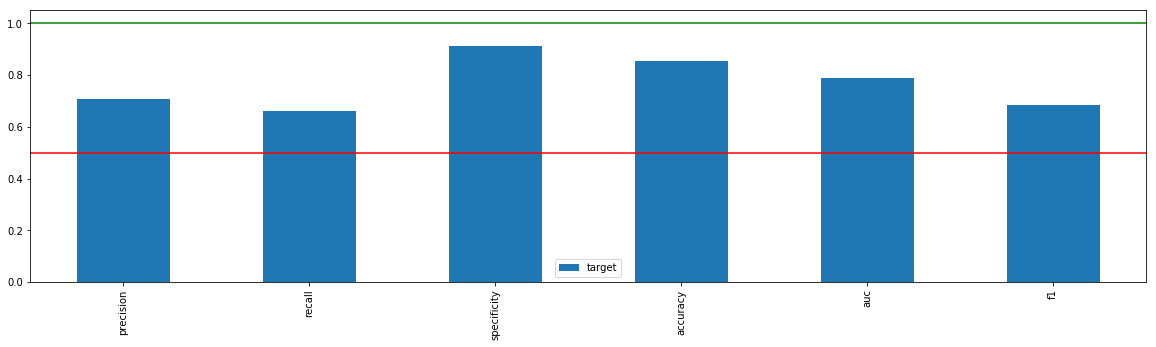

In [105]:
import xai
pred = clf.predict(preprocessor.transform(X_test))
xai.metrics_plot(y_test, pred)

## 2) Containerise and deploy your model

The steps to cotainerise a model with Seldon are always consistent, and require the following steps:

1) Save the model artefacts in the model folder

2) Write a wrapper with a `predict` function

3) Add the python requirements

4) Add the Source2Image configuration so the script knows which Model.py file to use

5) Run the s2i command to build the image

6) Deploy your image with a Seldon Graph Definition

### Once you've deployed it, you are able to test it with Curl or with our Python SeldonClient

Let's start containerising it - we'll be using the following folder for this:

In [ ]:
!mkdir -p pipeline/pipeline_steps/loanclassifier

### 2.1 - Save the trained model in the folder 

In [130]:
import dill

with open("pipeline/pipeline_steps/loanclassifier/preprocessor.dill", "wb") as prep_f:
    dill.dump(preprocessor, prep_f)
    
with open("pipeline/pipeline_steps/loanclassifier/model.dill", "wb") as model_f:
    dill.dump(clf, model_f)

### 2.2 - Write a python wrapper for the loan approval model

In [144]:
%%writefile pipeline/pipeline_steps/loanclassifier/Model.py
import dill

class Model:
    def __init__(self, *args, **kwargs):
        
        with open("preprocessor.dill", "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open("model.dill", "rb") as model_f:
            self.clf = dill.load(model_f)
        
    def predict(self, X, feature_names=[]):
        print("Received: " + str(X))
        X_prep = self.preprocessor.transform(X)
        proba = self.clf.predict_proba(X_prep)
        print("Predicted: " + str(proba))
        return proba

Overwriting pipeline/pipeline_steps/loanclassifier/Model.py


### 2.3 - Add the python requirements for the image

In [149]:
%%writefile pipeline/pipeline_steps/loanclassifier/requirements.txt
scikit-learn==0.20.1
dill==0.2.9

Overwriting pipeline/pipeline_steps/loanclassifier/requirements.txt


### 2.4 - Create the source2image configuration file

In [120]:
!mkdir -p pipeline/pipeline_steps/loanclassifier/.s2i

In [231]:
%%writefile pipeline/pipeline_steps/loanclassifier/.s2i/environment
MODEL_NAME=Model
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Overwriting pipeline/pipeline_steps/loanclassifier/.s2i/environment


### 2.5 - Now we can build the image

In [150]:
!s2i build pipeline/pipeline_steps/loanclassifier seldonio/seldon-core-s2i-python3:0.6 loanclassifier:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Stored in directory: /root/.cache/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
Successfully built dill
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


### 2.6 - And deploy it to Kubernetes

In [230]:
%%writefile pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier
spec:
  name: loanclassifier
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier:0.1
          name: model
    graph:
      children: []
      name: model
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier
    replicas: 1

Overwriting pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml


In [171]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier created


In [174]:
!kubectl get pods

NAME                                                     READY   STATUS    RESTARTS   AGE
ambassador-c8f5c967c-4p45t                               1/1     Running   0          85s
ambassador-c8f5c967c-rnk2l                               1/1     Running   0          85s
ambassador-c8f5c967c-sfdgq                               1/1     Running   0          85s
loanclassifier-loanclassifier-164157f-69b7b957b6-pbqjk   2/2     Running   0          32s
seldon-operator-controller-manager-0                     1/1     Running   3          92s


### Now that it's deployed we can test it with curl

In [179]:
# We'll use the output of the first item:
X_test[:1]

array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])

In [178]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]]}}" \
    http://localhost/seldon/default/loanclassifier/api/v0.1/predictions

{
  "meta": {
    "puid": "haa01nhtdnjkutv401muqpkvr",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model": "loanclassifier:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1"],
    "ndarray": [[0.86, 0.14]]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   355  100   263  100    92   6116   2139 --:--:-- --:--:-- --:--:--  8068


### And we can also test it with the Python SeldonClient

In [196]:
from seldon_core.seldon_client import SeldonClient

batch = X_test[:1]

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:80",
    deployment_name="loanclassifier",
    payload_type="ndarray",
    namespace="default",
    transport="rest")

client_prediction = sc.predict(data=batch)

print(client_prediction)

Success:True message:
Request:
data {
  ndarray {
    values {
      list_value {
        values {
          number_value: 52.0
        }
        values {
          number_value: 4.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 2.0
        }
        values {
          number_value: 8.0
        }
        values {
          number_value: 4.0
        }
        values {
          number_value: 2.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 60.0
        }
        values {
          number_value: 9.0
        }
      }
    }
  }
}

Response:
meta {
  puid: "mljep28gdusnn3938l04vvu77i"
  requestPath {
    key: "model"
    value: "loanclassifier:0.1"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          nu

## 3) Create an explainer to understand predictions

In [187]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: clf.predict(preprocessor.transform(x))
explainer = AnchorTabular(predict_fn, feature_names, categorical_names=category_map)

In [107]:
explainer.fit(X_train, disc_perc=[25, 50, 75])

In [111]:
idx = 0
class_names = ['<=50K', '>50K']
predict_fn(X_test[idx].reshape(1, -1))

array([0])

In [246]:
X_train[:1]

array([[27,  4,  4,  2,  1,  4,  4,  0,  0,  0, 44,  9]])

In [113]:
explanation = explainer.explain(X_test[idx], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.99
Coverage: 0.11


### However we need to explain our remotely deployed model in production

For this we can actually create a `predict_remote_fn` that uses our SeldonClient to interact with the production model

In [332]:
from seldon_core.utils import get_data_from_proto

def predict_remote_fn(X):
    from seldon_core.seldon_client import SeldonClient
    from seldon_core.utils import get_data_from_proto
    
    kwargs = {
        "gateway": "ambassador", 
        "deployment_name": "loanclassifier",
        "payload_type": "ndarray",
        "namespace": "default",
        "transport": "rest"
    }
    
    try:
        kwargs["gateway_endpoint"] = "localhost:80"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    except:
        # If we are inside the container, we need to reach the ambassador service directly
        kwargs["gateway_endpoint"] = "ambassador:80"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    
    y = get_data_from_proto(prediction.response)
    return y

# So the anchor is now connected with the remote model
explainer = AnchorTabular(predict_remote_fn, feature_names, categorical_names=category_map)

#### We train the anchor explainer with the remote model

In [333]:
explainer.fit(X_train, disc_perc=[25, 50, 75])

#### We now can get explanations of the remote model

In [334]:
explanation = explainer.explain(X_test[idx], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.95
Coverage: 0.11


## 4) Containerise and deploy your explainer

Once again we will follow the same steps to cotainerise a model with Seldon are always consistent, and require the following steps:

1) Save the model artefacts in the model folder

2) Write a wrapper with a `predict` function

3) Add the python requirements

4) Add the Source2Image configuration so the script knows which Model.py file to use

5) Run the s2i command to build the image

6) Deploy your image with a Seldon Graph Definition

### Once you've deployed it, you are able to test it with Curl or with our Python SeldonClient

Let's start containerising it - we'll be using the following folder for this:

In [211]:
!mkdir -p pipeline/pipeline_steps/loanclassifier-explainer

#### 1) Save the model artefacts in the model folder

In [335]:
import dill

with open("pipeline/pipeline_steps/loanclassifier-explainer/explainer.dill", "wb") as x_f:
    dill.dump(explainer, x_f)

#### 2) Write a wrapper with a `predict` function

In [354]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/Explainer.py
import dill
import json
import numpy as np

class Explainer:
    def __init__(self, *args, **kwargs):
        
        with open("explainer.dill", "rb") as x_f:
            self.explainer = dill.load(x_f)
        
    def predict(self, X, feature_names=[]):
        print("Received: " + str(X))
        explanation = self.explainer.explain(X)
        print("Predicted: " + str(explanation))
        return json.dumps(explanation, cls=NumpyEncoder)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (
        np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

Overwriting pipeline/pipeline_steps/loanclassifier-explainer/Explainer.py


#### 3) Add the python requirements

In [289]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/requirements.txt
scikit-learn==0.20.1
dill==0.2.9
alibi==0.2.0
seldon-core==0.3.0

Overwriting pipeline/pipeline_steps/loanclassifier-explainer/requirements.txt


#### 4) Add the Source2Image configuration so the script knows which Model.py file to use

In [222]:
!mkdir pipeline/pipeline_steps/loanclassifier-explainer/.s2i

In [223]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/.s2i/environment
MODEL_NAME=Explainer
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Writing pipeline/pipeline_steps/loanclassifier-explainer/.s2i/environment


#### 5) Run the s2i command to build the image

In [355]:
!s2i build pipeline/pipeline_steps/loanclassifier-explainer seldonio/seldon-core-s2i-python3:0.6 loanclassifier-explainer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl


Stored in directory: /root/.cache/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
Stored in directory: /root/.cache/pip/wheels/2b/9f/33/f5ae3ed41c467ee0a261747216a5cdd22359c2ff2a628d2c0f
Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Stored in directory: /root/.cache/pip/wheels/6b/b9/15/c8c6a1e095a370e8c3273e65a5c982e5cf355dde16d77502f5
Successfully built dill jaeger-client networkx pyrsistent
Found existing installation: jaeger-client 4.0.0
Uninstalling jaeger-client-4.0.0:
Successfully uninstalled jaeger-client-4.0.0
Found existing installation: seldon-core 0.2.7
Uninstalling seldon-core-0.2.7:
Successfully uninstalled seldon-core-0.2.7
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


#### 6) Deploy your image with a Seldon Graph Definition

In [298]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier-explainer
spec:
  name: loanclassifier-explainer
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier-explainer:0.1
          name: model-explainer
    graph:
      children: []
      name: model-explainer
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier-explainer
    replicas: 1

Overwriting pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml


In [357]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier-explainer created


In [358]:
!kubectl get pods

NAME                                                              READY   STATUS    RESTARTS   AGE
ambassador-c8f5c967c-4p45t                                        1/1     Running   1          6h42m
ambassador-c8f5c967c-rnk2l                                        1/1     Running   0          6h42m
ambassador-c8f5c967c-sfdgq                                        1/1     Running   1          6h42m
loanclassifier-explainer-loanclassifier-explainer-8444816-lqv66   2/2     Running   0          2m28s
loanclassifier-loanclassifier-164157f-69b7b957b6-pbqjk            2/2     Running   0          6h41m
seldon-operator-controller-manager-0                              1/1     Running   3          6h42m


### Now that it's deployed we can query it

#### First we can try Curl

In [359]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]]}}" \
    http://localhost/seldon/default/loanclassifier-explainer/api/v0.1/predictions

{
  "meta": {
    "puid": "snugmu5nusqp0oeqlch4bhd7o7",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model-explainer": "loanclassifier-explainer:0.1"
    },
    "metrics": []
  },
  "strData": "{\"names\": [\"Marital Status = Separated\", \"Sex = Female\"], \"precision\": 0.953307392996109, \"coverage\": 0.1094, \"raw\": {\"feature\": [3, 7], \"mean\": [0.8751560549313359, 0.953307392996109], \"precision\": [0.8751560549313359, 0.953307392996109], \"coverage\": [0.1815, 0.1094], \"examples\": [{\"covered\": [[21, 4, 4, 2, 1, 3, 4, 0, 0, 0, 15, 9], [22, 4, 1, 2, 6, 1, 4, 1, 0, 0, 40, 9], [22, 4, 3, 2, 6, 3, 4, 1, 0, 0, 50, 9], [45, 6, 1, 2, 8, 4, 4, 1, 0, 0, 50, 9], [53, 7, 4, 2, 8, 1, 4, 1, 0, 1092, 40, 9], [45, 5, 4, 2, 6, 0, 4, 1, 0, 0, 40, 9], [51, 0, 0, 2, 0, 0, 4, 1, 0, 0, 50, 9], [59, 4, 4, 2, 6, 4, 2, 0, 0, 0, 40, 9], [53, 4, 4, 2, 2, 0, 4, 1, 0, 2002, 40, 9], [21, 4, 4, 2, 2, 1, 4, 1, 0, 0, 35, 5]], \"covered_true\": [[51, 5, 0, 2, 6, 1, 4, 0, 0, 0, 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3493  100  3401  100    92   1231     33  0:00:02  0:00:02 --:--:--  1265


## 5) Test production predictions and explanations

We create a seldon client to send requests to the deployed model as well as the explainer. Here is the diagram of the deployed models:

![](img/deploy-overview.jpg)


In [390]:
sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:80",
    payload_type="ndarray",
    namespace="default",
    transport="rest")

### Let's have a look at the datapoint we'll use for this prediction

In [372]:
to_explain = X_test[:1]
print(to_explain)

[[52  4  0  2  8  4  2  0  0  0 60  9]]


### We get the prediction from the model in production

In [394]:
resp = sc_pred.predict(data=to_explain, deployment_name="loanclassifier").response
pred = get_data_from_proto(resp)
print('Predicted Label: %s' % ("POSITIVE" if pred[0][0] < 0.5 else "NEGATIVE"))
print('Predicted Probabilities: %s' % pred[0])

Predicted Label: NEGATIVE
Predicted Probabilities: [0.86 0.14]


### By checking our test label, we can see it is indeed correct

In [397]:
print('Actual Label: %s' % ("POSITIVE" if y_valid[0] == 1 else "NEGATIVE"))

Actual Label: NEGATIVE


### Now we can use our deployed explainer to explain our prediction

In [403]:
import json
explanation = sc_xai.predict(data=to_explain, deployment_name="loanclassifier-explainer")
exp = json.loads(explanation.response.strData)

print('Anchor: %s' % (' AND '.join(exp['names'])))

Anchor: Marital Status = Separated AND Sex = Female
